# Importing Dependencies

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

# Downloading Images

Copy this code in google console to create .txt file which contains URLs to image
// Google Images<br/>
<b>var urls=Array.from(document.querySelectorAll(".rg_i")).map(el=>el.hasAttribute("data-src")?el.getAttribute("data-src"):el.getAttribute("data-iurl")).filter(l=>l!=null).join("\n");
var a = document.createElement("a");a.download = "filename.txt";a.href = "data:text/csv;charset=utf-8,"+urls;a.click();</b>

In [44]:
folder = 'Biryani'
file = '/storage/Food/Biryani.txt'

In [42]:
folder = 'Pulao'
file = '/storage/Food/Pulao.txt'

In [36]:
folder = 'Chinese Pulao'
file = '/storage/Food/Chinese Pulao.txt'

In [45]:
path = Path('storage/Food/Data')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [15]:
classes = ['Biryani','Pulao','Chinese Pulao']

In [46]:
download_images(path/file, dest, max_pics=200)

In [47]:
#Then we can remove any images that can't be opened:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)


Biryani


Pulao


Chinese Pulao


In [48]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [49]:
data.classes

['Biryani', 'Chinese Pulao', 'Pulao']

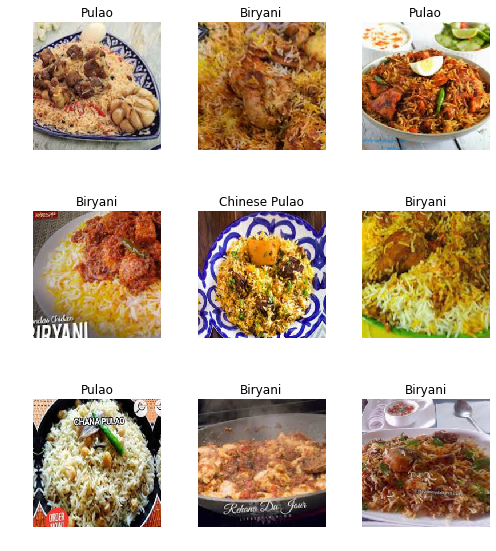

In [50]:
data.show_batch(rows=3, figsize=(7,8))

In [51]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Biryani', 'Chinese Pulao', 'Pulao'], 3, 480, 120)

## Train the RESNET34 Model

In [52]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [53]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.926099,1.406906,0.591667,00:04
1,1.732182,1.615936,0.541667,00:03
2,1.577066,1.724795,0.591667,00:03
3,1.469977,1.684355,0.566667,00:03


In [54]:
learn.save('stage-1')

In [55]:
learn.unfreeze()

In [56]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


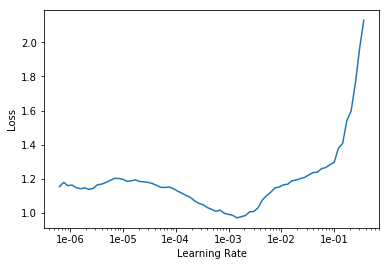

In [57]:
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,10e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.773798,1.741280,0.558333,00:03
1,0.710043,1.596449,0.516667,00:03


In [60]:
accuracy = 100 - (0.51667*100)
accuracy

48.333000000000006

In [61]:
learn.save("stage2")

## Train the RESNET50 Model


In [64]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [65]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.022933,1.737470,0.600000,00:07
1,1.844539,2.086114,0.508333,00:04
2,1.674602,1.899946,0.516667,00:04
3,1.483991,1.877659,0.550000,00:04


In [66]:
learn.save('resnet50-stage-1')

In [67]:
learn.unfreeze()

In [68]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


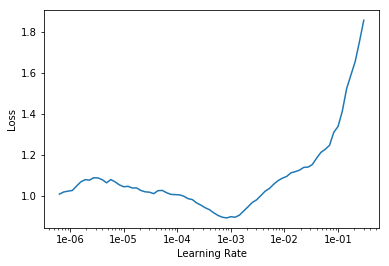

In [69]:
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,10e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.481350,2.190993,0.525000,00:05
1,0.468541,2.088815,0.491667,00:05


In [73]:
learn.save("Resnet50-stage2")

## Interpretation


In [74]:
learn.load('Resnet50-stage2');

In [75]:
interp = ClassificationInterpretation.from_learner(learn)

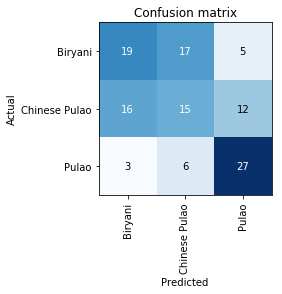

In [76]:
interp.plot_confusion_matrix()

## Cleaning the Data

In [79]:
from fastai.widgets import *

In [80]:
losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [82]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [83]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [84]:
learn.save("clean learn")

In [85]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [86]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [87]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


## Retraining the Model

In [88]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [89]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.863625,1.387248,0.608333,00:03
1,1.681827,1.890732,0.558333,00:02
2,1.554921,1.695475,0.500000,00:03
3,1.421527,1.606031,0.541667,00:02


In [90]:
learn.unfreeze()

In [91]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


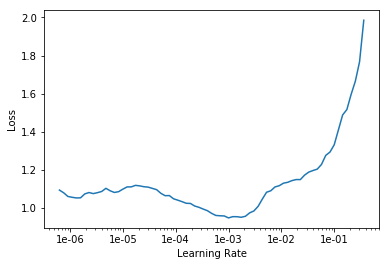

In [92]:
learn.recorder.plot()

In [94]:
learn.fit_one_cycle(2, max_lr=slice(1e-04,0.9*1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.968762,1.656187,0.525000,00:03
1,0.824566,1.740659,0.525000,00:03
